In [1]:
from torch.utils.data import Dataset
import pandas as pd
import os
from random import shuffle
import json
import csv
import torch
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Wang et al. (2020) recreation

Okay, so let's at least try and recreate a dataset which loads into use for a convolutional neural network first.

So based on the paper by Wang et al. (2020) accessed [here](https://www.sciencedirect.com/science/article/pii/S0142061519318502), it would appear that datapoints are ordered into first daily (i.e., 48 points) and then from there resampled.

Let's try with 1 meter (meter 1000) to start our code:

In [2]:
df = pd.read_csv('../../dataset/interim/cern_train.csv', parse_dates=['timestamp']) # Okay to read direct to memory as only 4gb, in future consider pyspark or dask for distributed processing.

In [3]:
meter_1000 = df[df['metre_id'] == 1000].kwh.to_numpy()

In [4]:
meter_1000.shape

(24384,)

In [5]:
meter_1000_reshaped = meter_1000.reshape(-1, 1, 48)

Visually check

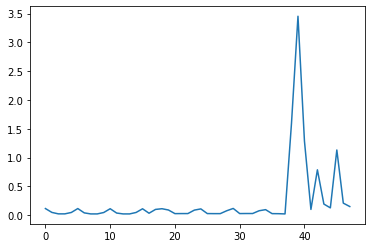

In [6]:
plt.plot(meter_1000_reshaped[0,0,:])

In [7]:
df[df['metre_id'] == 1000].iloc[:5]

,metre_id,timestamp,kwh
0,1000.0,2009-07-14 00:29:59,0.117
1,1000.0,2009-07-14 00:59:59,0.050
2,1000.0,2009-07-14 01:29:59,0.025
3,1000.0,2009-07-14 01:59:59,0.025
4,1000.0,2009-07-14 02:29:59,0.049


Looks great, the next part is to actually vectorize the whole operation. Unfortunately as not all households are equally represented, we can't do a simple reshape. We'll have to use pandas groupby and then stack it?

Actually, becuase of the way I preprocessed it - it's simple! I'm overcomplicating it now. All I have to do is just divide the whole thing into 48 blocks.

Quickly check that all are "days"

In [8]:
one_full_day_timedelta = pd.to_timedelta('0 days 23:30:00')

def check_all_are_days(df):
    
    max_check = df.timestamp.max().time() == datetime.time(23, 59, 59)
    min_check = df.timestamp.min().time() == datetime.time(0, 29, 59)
    period_check = (df.timestamp.max() - df.timestamp.min()) == one_full_day_timedelta
    
    return max_check and min_check and period_check

In [9]:
df.iloc[:48*2,]

,metre_id,timestamp,kwh
0,1000.0,2009-07-14 00:29:59,0.117
1,1000.0,2009-07-14 00:59:59,0.050
2,1000.0,2009-07-14 01:29:59,0.025
3,1000.0,2009-07-14 01:59:59,0.025
4,1000.0,2009-07-14 02:29:59,0.049
...,...,...,...
91,1000.0,2009-07-15 21:59:59,0.353
92,1000.0,2009-07-15 22:29:59,0.322
93,1000.0,2009-07-15 22:59:59,0.210
94,1000.0,2009-07-15 23:29:59,0.184


In [10]:
df['dayindex'] = df.index // 48
g = df.groupby('dayindex')

# Randomly test groups
a = np.arange(g.ngroups)
np.random.shuffle(a)

sum(df[g.ngroup().isin(a[:10000])].groupby('dayindex').apply(check_all_are_days))

10000

Great, so we randomly test 10000 day groups and they're all good!

Now all we have to do is just split evenly into groups of 48!

In [11]:
cern_tensor = torch.from_numpy(df.kwh.to_numpy())

In [12]:
cern_tensor = cern_tensor.reshape(-1, 1, 48)

In [13]:
cern_tensor = cern_tensor[:(cern_tensor.shape[0] // 12) * 12, :, :] # Force correct reshape by dropping last

In [14]:
cern_tensor = cern_tensor.reshape(-1, 12, 48)

In [15]:
cern_tensor.shape

torch.Size([208402, 12, 48])

In [16]:
cern_tensor.shape[2] / 2

24.0

In [17]:
cern_tensor = cern_tensor.reshape(cern_tensor.shape[0], cern_tensor.shape[1] * 2, cern_tensor.shape[2] // 2)

In [18]:
df.iloc[24:30]

,metre_id,timestamp,kwh,dayindex
24,1000.0,2009-07-14 12:29:59,0.111,0
25,1000.0,2009-07-14 12:59:59,0.030,0
26,1000.0,2009-07-14 13:29:59,0.029,0
27,1000.0,2009-07-14 13:59:59,0.029,0
28,1000.0,2009-07-14 14:29:59,0.079,0
29,1000.0,2009-07-14 14:59:59,0.119,0


Borrow randomiser from https://discuss.pytorch.org/t/torch-equivalent-of-numpy-random-choice/16146

In [19]:
# perm = torch.randperm(cern_tensor.size(0))
# idx = perm[:5]
# samples = tensor[idx]

**OKAY 25 AUGUST 2022**

So...turns out I don't think we can have hybrid matricies. I believe that's what's resulting in our terrible training. Remove hybrid datasets.

In [ ]:
df.metre_id.unique()

In [ ]:
test_single = df[df['metre_id'] == 1210]

In [ ]:
test_single_torch = torch.from_numpy(test_single.kwh.to_numpy())
test_single_torch = test_single_torch.reshape(-1, 1, 48) # reshape into days

In [ ]:
test_single_torch.shape

In [ ]:
min_test, _ = torch.min(test_single_torch, dim = 2, keepdim=True)
max_test, _ = torch.max(test_single_torch, dim = 2, keepdim=True)

In [ ]:
min_test.shape

In [ ]:
test_single_torch = (test_single_torch - min_test) / (max_test - min_test)

In [ ]:
test_single_torch = test_single_torch[:(test_single_torch.shape[0] // 12) * 12, :, :] # drop extra rows (cannot be used)
test_single_torch = test_single_torch.reshape(-1, 12, 48)

In [ ]:
test_single_torch.max()

In [ ]:
test_single_torch.min()

In [ ]:
test_multiple = df.copy()

In [ ]:
all_examples = torch.zeros(1, 12, 48)

def extract_cern_examples(df, no_days = 12):
    
    meter_torch = torch.from_numpy(df.kwh.to_numpy())
    meter_torch = meter_torch.reshape(-1, 1, 48) # reshape into days
    
    # min max normalize
    min_meter_day, _ = torch.min(meter_torch, dim = 2, keepdim=True)
    max_meter_day, _ = torch.max(meter_torch, dim = 2, keepdim=True)
    meter_torch = (meter_torch - min_meter_day) / (max_meter_day - min_meter_day + 1e-12)
    
    meter_torch = meter_torch[:(meter_torch.shape[0] // no_days) * no_days, :, :] # drop extra rows (cannot be used)
    meter_torch = meter_torch.reshape(-1, 12, 48)
    
    global all_examples
    all_examples = torch.cat((all_examples, meter_torch))
    
    return None

Must be more efficient non-Pandas (numpy or torch) way of doing this...

TODO: get someone to check and revise this, this doesn't feel Pythonic nor does it feel efficient.

In [ ]:
tqdm.pandas()
test_multiple.groupby('metre_id').progress_apply(extract_cern_examples)

In [ ]:
all_examples = all_examples[1:, :, :]

In [ ]:
all_examples.shape

In [ ]:
all_examples.reshape(-1, 48)[83686]

In [ ]:
all_examples.reshape(-1, 48)[83685]

Now let's also create inputs for basic AE:

In [ ]:
test_fc = torch.from_numpy(df.kwh.to_numpy())

test_fc = test_fc.reshape(-1, 48)

min_meter_day, _ = torch.min(test_fc, dim = 1, keepdim=True)
max_meter_day, _ = torch.max(test_fc, dim = 1, keepdim=True)
test_fc = (test_fc - min_meter_day) / (max_meter_day - min_meter_day + 1e-12) # numerica stabilit

test_fc.reshape()

In [ ]:
test_fc

In [24]:
class CERN_Dataset_CNN(Dataset):

    def __init__(self, folder_path: str ='../../dataset/interim/', mode: str = 'cnn', # Required arguments
                 train: bool = True, no_days: int = 12, reshape_factor: int = 2, # CNN arguments
                 fc_days = 1, # FC arguments
                 N: int = None, seed: int = 0, eps: float = 1e-12): # Other arguments

        """
        Custom dataset for CERN (Irish Dataset, 30 minute freq)
        All Tensor operations performed on CPU as minor operations only
        
        Args:
            folder_path (string): Directory with all the files (processed)
            mode (string): Either 'cnn' for convolutional usage or 'fc' for basic AE usage.
            train (bool): Determines whether training or test dataset to be used (already preprocessed to save time)
            no_days (int, optional): Number of days (i.e., rows in the matrix example)
            reshape_factor (int, optional): Used by the original authors to achieve a square tensor
            N (int, optional): Select subset of examples
            seed (int, optional): Set seed, mainly for shuffling
            eps (float, optional): For numerical stability in min-max normalization.
        """
        
        # Set seed
        torch.manual_seed(seed)
        
        # Activate tqdm for pandas and remember object variables
        tqdm.pandas()
        self.eps = eps
        self.mode = mode
        
        if train:
            file_path = folder_path + 'cern_train.csv'
        else:
            file_path = folder_path + 'cern_test.csv' # Note that this has all been directly preprocessed to reduce time spent reprocessing.

        df = pd.read_csv(file_path)
        
        if mode == 'cnn':
        
            # Perform first reshape into Tensor of shape (no_examples, no_days, 48)
            self.cern_data = self.preprocess_cern_cnn(df, no_days)


            # Perform second reshape into Tensor of shape (no_examples, no_days * reshape_factor, 48 / reshape_factor)        
            self.cern_data = self.cern_data.reshape(self.cern_data.size(0), self.cern_data.size(1) * reshape_factor,
                                                    self.cern_data.size(2) // reshape_factor)

            # If N is selected, pick random list
            if N is not None:
                if N > self.cern_data.shape[0]:
                    raise ValueError("Cannot exceed dataset size of {}".format(self.cern_data.size(0)))
                else:
                    # Permutation
                    # perm = torch.randperm(self.cern_data.size(0))[:N]
                    # self.cern_data = self.cern_data[perm, :, :]

                    self.cern_data = self.cern_data[:N, :, :] # for debug purposes

            # Unsqueeze channel 1 back out (1 filter)
            self.cern_data = self.cern_data.unsqueeze(1)
            
        elif mode == 'fc':
            
            self.cern_data = self.preprocess_cern_fc(df, fc_days)
            
        else:
            
            raise ValueError("Mode must be 'cnn' or 'fc'.")
        
    def __len__(self):
        return self.cern_data.size(0)
    
    def preprocess_cern_fc(self, df, fc_days):
        
        return_torch = torch.zeros(1, fc_days * 48)
        
        def extract_cern_examples(subset_df, fc_days):
            
            """
            Nested function; group-by to modify nonlocal variable self.return_torch and attaches all modified examples.
            """
    
            meter_torch = torch.from_numpy(subset_df.kwh.to_numpy()).float() # conver to Tnesor
            meter_torch = meter_torch.reshape(-1, 48) # reshape into days
            
            # Min max normalizes all tensors (will need to save these values realistically)
            min_meter_day, _ = torch.min(meter_torch, dim = 1, keepdim=True)
            max_meter_day, _ = torch.max(meter_torch, dim = 1, keepdim=True)
            meter_torch = (meter_torch - min_meter_day) / (max_meter_day - min_meter_day + self.eps) # numerica stability
            
            meter_torch = meter_torch[:(meter_torch.shape[0] // fc_days) * fc_days, :] # drop extra rows (cannot be used)
            meter_torch = meter_torch.reshape(-1, fc_days * 48) # reshape to daily form

            nonlocal return_torch # binds to non-global variable, which will be in non-nested function
            return_torch = torch.cat((return_torch, meter_torch))
        
        # nb: Below function does not need to be assigned, as effectively modifies return_torch inplace.
        df.groupby('metre_id').progress_apply(extract_cern_examples, fc_days = fc_days)
        
        return return_torch[1:, :] # Removes first row of 0s
    
    def preprocess_cern_cnn(self, df, no_days):
        
        return_torch = torch.zeros(1, 12, 48)
        
        def extract_cern_examples(subset_df, no_days):
            
            """
            Nested function; group-by to modify nonlocal variable self.return_torch and attaches all modified examples.
            """
    
            meter_torch = torch.from_numpy(subset_df.kwh.to_numpy()).float() # conver to Tnesor
            meter_torch = meter_torch.reshape(-1, 1, 48) # reshape into days
            
            # Min max normalizes all tensors (will need to save these values realistically)
            min_meter_day, _ = torch.min(meter_torch, dim = 2, keepdim=True)
            max_meter_day, _ = torch.max(meter_torch, dim = 2, keepdim=True)
            meter_torch = (meter_torch - min_meter_day) / (max_meter_day - min_meter_day + self.eps) # numerica stability
            
            meter_torch = meter_torch[:(meter_torch.shape[0] // no_days) * no_days, :, :] # drop extra rows (cannot be used)
            meter_torch = meter_torch.reshape(-1, no_days, 48) # reshape to 12 day form

            nonlocal return_torch # binds to non-global variable, which will be in non-nested function
            return_torch = torch.cat((return_torch, meter_torch))
        
        # nb: Below function does not need to be assigned, as effectively modifies return_torch inplace.
        df.groupby('metre_id').progress_apply(extract_cern_examples, no_days = no_days)
        
        return return_torch[1:, :, :] # Removes first row of 0s

    def __getitem__(self, idx):
        
        example = self.cern_data[idx]

        return example

Let's test the class

In [25]:
my_dataset = CERN_Dataset_CNN(mode = 'fc', fc_days = 2)

100%|██████████| 4926/4926 [02:32<00:00, 32.29it/s]


In [26]:
len(my_dataset)

1250400

In [28]:
my_dataset[4].shape

torch.Size([96])

Let's test it in a dataloader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
my_dataloader = DataLoader(my_dataset, batch_size = 64)

In [ ]:
next(iter(my_dataloader)).shape

Let's visualise these for autocorrelations

In [ ]:
import seaborn as sns

In [ ]:
import random

In [ ]:
random.randint(0, len(my_dataset))

In [ ]:
len(my_dataset)

In [ ]:
df.loc[66*48*12:66*48*12+20]

In [ ]:
df.timestamp.min()

In [ ]:
df.timestamp.max()

In [ ]:
1188026 / len(df)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

for i, ax in zip([64, 65, 66, 67], axes.reshape(-1)):
    
    sns.heatmap(my_dataset[i], ax=ax)
    ax.set_title('id: {}'.format(i))
    
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

for i, ax in zip([random.randint(0, len(my_dataset)) for i in range(4)], axes.reshape(-1)):
    
    sns.heatmap(my_dataset[i], ax=ax)
    ax.set_title('id: {}'.format(i))
    
plt.show()

OKAY, experiment with this for now, but we **have to** come back and think about how we're stacking the days.

Effectively right now, it's just meter id first, and then half days or whatever second, this is not the best way to do it.